In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from pathlib import Path
import xgboost as xgb
from sklearn import metrics
from itertools import combinations


In [12]:
# LOGISTIC REGRESSION
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

# DATA PATHS
POSITIVES_PATH = Path("src/final_data/roadsigns/positive_samples_roadsigns_200.csv")
NEGATIVES_PATH_TRUE = Path("src/final_data/roadsigns/negative_samples_roadsigns_200.csv")
NEGATIVES_PATH_FALSE = Path("src/final_data/roadsigns/TMP_negative_samples_roadsigns_200.csv")


# POSITIVE SAMPLE roadsigns
POSITIVES = pd.read_csv(POSITIVES_PATH)

# NEGATIVE SAMPLE roadsigns
NEGATIVES_TRUE = pd.read_csv(NEGATIVES_PATH_TRUE)
NEGATIVES_FALSE = pd.read_csv(NEGATIVES_PATH_FALSE)

# OUTPUTS
POSITIVES['label'] = 1
NEGATIVES_TRUE['label'] = 0
NEGATIVES_FALSE['label'] = 0

# COMMON COLUMNS
POSITIVES.columns=[c.strip() for c in POSITIVES.columns]
NEGATIVES_TRUE.columns=[c.strip() for c in NEGATIVES_TRUE.columns]
NEGATIVES_FALSE.columns=[c.strip() for c in NEGATIVES_FALSE.columns]

common_columns = list(np.intersect1d(POSITIVES.columns, NEGATIVES_TRUE.columns))

# CONCATENATE POSITIVES AND NEGATIVES
DATA = pd.concat([POSITIVES[common_columns],
                  NEGATIVES_TRUE[common_columns],
                  NEGATIVES_FALSE[common_columns]])
DATA = DATA[['label'] + [col for col in DATA.columns if col != 'label']]

X = DATA.drop('label', axis=1)
y = DATA['label']

# Handling the date column
X['Date'] = pd.to_datetime(X['Date'])
X['Year'] = X['Date'].dt.year
X['Month'] = X['Date'].dt.month
X['Day'] = X['Date'].dt.day
X['DayOfWeek'] = X['Date'].dt.dayofweek
X.drop('Date', axis=1, inplace=True)

# Encode categorical variables
categorical_features = X.select_dtypes(include=['object', 'bool']).columns.tolist()
for feature in categorical_features:
    X[feature] = X[feature].astype(str)

# Setting up the preprocessing pipeline for numerical features
numerical_features = X.select_dtypes(include=['float64', 'int64']).columns
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values
    ('scaler', StandardScaler())
])

# Setting up Column Transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_features),
        ('num', numerical_pipeline, numerical_features)
    ],
    remainder='passthrough'
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

X_train_preprocessed = np.nan_to_num(X_train_preprocessed, nan=np.nan)
X_test_preprocessed = np.nan_to_num(X_test_preprocessed, nan=np.nan)

models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(random_state=42)
}

performance = {}

for model_name, model in models.items():
    model.fit(X_train_preprocessed, y_train)
    y_pred = model.predict(X_test_preprocessed)
    accuracy = accuracy_score(y_test, y_pred)
    performance[model_name] = {'Accuracy': accuracy} 
    
print(performance)

{'Logistic Regression': {'Accuracy': 0.76431718061674}, 'Decision Tree': {'Accuracy': 0.6607929515418502}, 'Random Forest': {'Accuracy': 0.7422907488986784}, 'SVM': {'Accuracy': 0.6343612334801763}}


# XGBOOST

In [14]:
X.columns

Index(['Bouwwerk', 'Buispaal', 'Flespaal', 'Gemiddelde hoogte onderkant bord',
       'Gemiddelde kijkrichting', 'Hekwerk', 'Hour', 'Lichtmast', 'Mast',
       'Muur', 'Overig', 'Portaal', 'Scheiding', 'VRI-Mast',
       'apparent_temperature', 'dew_point_2m', 'grid_id', 'has_roadsign',
       'precipitation', 'pressure_msl', 'rain', 'relative_humidity_2m',
       'snow_depth', 'snowfall', 'soil_moisture_0_to_7cm',
       'soil_moisture_100_to_255cm', 'soil_moisture_28_to_100cm',
       'soil_moisture_7_to_28cm', 'soil_temperature_0_to_7cm',
       'soil_temperature_100_to_255cm', 'soil_temperature_28_to_100cm',
       'soil_temperature_7_to_28cm', 'surface_pressure', 'temperature_2m',
       'weather_code', 'wind_direction_10m', 'wind_gusts_10m',
       'wind_speed_10m', 'Year', 'Month', 'Day', 'DayOfWeek'],
      dtype='object')

In [ ]:
# XGBOOST
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

# DATA PATHS
POSITIVES_PATH = Path("src/final_data/roadsigns/positive_samples_roadsigns_200.csv")
NEGATIVES_PATH_TRUE = Path("src/final_data/roadsigns/negative_samples_roadsigns_200.csv")
NEGATIVES_PATH_FALSE = Path("src/final_data/roadsigns/TMP_negative_samples_roadsigns_200.csv")
NEGATIVES_PATH_RANDOM = Path("src/final_data/roadsigns/TMP3_negative_samples_roadsigns_200.csv")

# POSITIVE SAMPLE roadsigns
POSITIVES = pd.read_csv(POSITIVES_PATH)

# NEGATIVE SAMPLE roadsigns
NEGATIVES_TRUE = pd.read_csv(NEGATIVES_PATH_TRUE)
NEGATIVES_FALSE = pd.read_csv(NEGATIVES_PATH_FALSE)
NEGATIVES_RANDOM = pd.read_csv(NEGATIVES_PATH_RANDOM)

# OUTPUTS
POSITIVES['label'] = 1
NEGATIVES_TRUE['label'] = 0
NEGATIVES_FALSE['label'] = 0
NEGATIVES_RANDOM['label'] = 0

# COMMON COLUMNS
POSITIVES.columns=[c.strip() for c in POSITIVES.columns]
NEGATIVES_TRUE.columns=[c.strip() for c in NEGATIVES_TRUE.columns]
NEGATIVES_FALSE.columns=[c.strip() for c in NEGATIVES_FALSE.columns]
NEGATIVES_RANDOM.columns=[c.strip() for c in NEGATIVES_RANDOM.columns]

common_columns = list(np.intersect1d(POSITIVES.columns, NEGATIVES_TRUE.columns))

# CONCATENATE POSITIVES AND NEGATIVES
DATA = pd.concat([POSITIVES[common_columns],
                  NEGATIVES_TRUE[common_columns],
                  NEGATIVES_FALSE[common_columns],
                  NEGATIVES_RANDOM[common_columns]])

DATA = DATA[['label'] + [col for col in DATA.columns if col != 'label']]

X = DATA#.drop('label', axis=1)
y = DATA['label']

X['has_roadsign'] = X['has_roadsign'].map({'True': True, True: True, 'False': False, False: False, '0': False})
X, y = X.drop(['label',
                'grid_id',
                'Date'], axis=1), X[['label']]

cats = X.select_dtypes(exclude=np.number).columns.tolist()

for col in cats:
   X[col] = X[col].astype(int)
   
# DETERMINE THE COLUMNS TO BE USED
X = X[['has_roadsign', 'Gemiddelde kijkrichting', 
       'Gemiddelde hoogte onderkant bord',
       'wind_gusts_10m', 
       'wind_direction_10m', 
       'Bouwwerk', 'Buispaal', 'Flespaal',
       'Hekwerk', 'Lichtmast', 'Mast',
       'Muur', 'Overig', 'Portaal', 'Scheiding', 'VRI-Mast']]

# SPLIT THE X
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=99)

# CREATING CLASSIFICATION MATRICES
dtrain_clf = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_clf = xgb.DMatrix(X_test, y_test, enable_categorical=True)
evals = [(dtrain_clf, "train"), (dtest_clf, "validation")]

# DEFINING HYPERPARAMETERS
best_params = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "max_depth": 1,
    "learning_rate": 0.01,
    "subsample": 0.8,
    "colsample_bytree": 1.0,
    "gamma": 0,
    "reg_alpha": 0.1,  
}

n = 1000

# MODEL TRAINING
model = xgb.train(
    params = best_params,
    dtrain = dtrain_clf, 
    num_boost_round = n, 
    verbose_eval = 250, 
    evals=evals,
    early_stopping_rounds=50,
)


y_pred_clf = model.predict(dtest_clf)
y_pred_labels = (y_pred_clf > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred_labels)
percentage_correct = accuracy * 100

# FEATURE IMPORTANCE PLOT
xgb.plot_importance(model)
plt.show()

print(f"Percentage of correctly classified labels: {percentage_correct:.2f}%")


In [54]:
# SAVE MODEL
import pickle

# Save the XGBoost model as a pickle file
with open("src/models/roadsigns/FINAL_xgboost_model_roadsigns.pkl", "wb") as model_file:
    pickle.dump(model, model_file)

# Print a message indicating that the model has been saved
print("XGBoost model saved successfully as a pickle file.")

XGBoost model saved successfully as a pickle file.


In [ ]:
# HYPERPARAMETER TUNING
# RUN ALLEEN VOOR TUNING
from sklearn.model_selection import GridSearchCV
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2],
    # 'reg_alpha': [0, 0.01, 0.1],  
    # 'reg_lambda': [0, 0.01, 0.1]  
}
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc', n_estimators=100)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='roc_auc', cv=3, verbose=2)
grid_search.fit(X_train, y_train)

print("Beste hyperparameters gevonden:")
print(grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

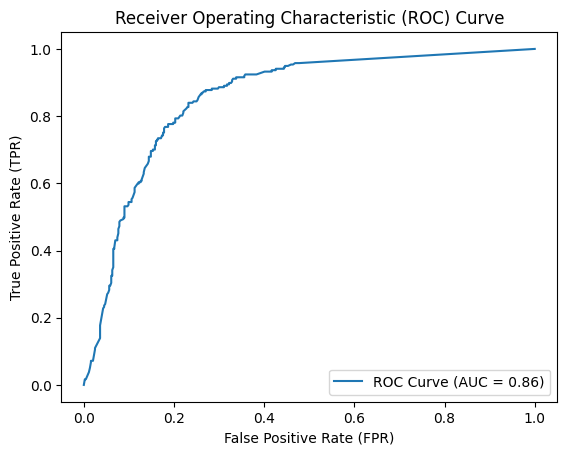

In [55]:
# ROC Curve
y_pred_clf = model.predict(dtest_clf)
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_clf)
auc = metrics.roc_auc_score(y_test, y_pred_clf)
plt.plot(fpr, tpr, label="ROC Curve (AUC = {:.2f})".format(auc))
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc=4)
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()

# INFERENCE

In [24]:
import pickle
import numpy
import requests_cache
import openmeteo_requests
import pandas as pd
from pathlib import Path
from retry_requests import retry

In [34]:
MODEL_DIR = Path("src/models/roadsigns/")
GRID_ENRICHED_PATH = Path("src/data_roadsigns/grid_enriched_roadsigns_200.csv")

LOCATION = ("4.890439", "52.369496")

FEATURE_COLS = ['Gemiddelde kijkrichting', 
       'Gemiddelde hoogte onderkant bord',
       'wind_gusts_10m', 
       'wind_direction_10m', 
       'Bouwwerk', 'Buispaal', 'Flespaal',
       'Hekwerk', 'Lichtmast', 'Mast',
       'Muur', 'Overig', 'Portaal', 'Scheiding', 'VRI-Mast']

HOURS_TO_PREDICT = 8

In [35]:
grid_df = pd.read_csv(GRID_ENRICHED_PATH, sep=",", encoding="utf-8")

def get_api_connection(self):
    # Setup the Open-Meteo API client with cache and retry on error
    self.cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
    self.retry_session = retry(self.cache_session, retries = 5, backoff_factor = 0.2)
    self.openmeteo = openmeteo_requests.Client(session = self.retry_session)

def request_weather(vars):
    # connect to API
    cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
    retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
    openmeteo = openmeteo_requests.Client(session = retry_session)

    latitude = LOCATION[0]
    longitude = LOCATION[1]

    url = "https://api.open-meteo.com/v1/forecast"
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "hourly": list(vars.keys()),
        "forecast_days" : 1,
    }
    responses = openmeteo.weather_api(url, params=params)

    return responses[0]

vars = {
    'wind_gusts_10m': None,
    'wind_direction_10m': None
}
response = request_weather(vars)

def extract_weather_vars(
    response,
    vars
):
    hourly = response.Hourly()

    # Fetch and process the first half of the variables
    for index, (name, _) in enumerate(vars.items()):
        vars[name] = hourly.Variables(index).ValuesAsNumpy()

    return vars

weather_vars = extract_weather_vars(response, vars)

def make_prediction(
    grid_df,
    clf
):
    pred_dict = {}
    for grid_id in grid_df.grid_id:
        pred_dict[grid_id] = []

    for i in range(HOURS_TO_PREDICT):
        grid = grid_df.copy()
        for var, values in weather_vars.items():
            grid[var] = values[i]
        grid['prediction'] = clf.predict(grid[FEATURE_COLS])
        for i, row in grid.iterrows():
            pred_dict[row['grid_id']].append(row['prediction'])

In [36]:
class makeTreePrediction():
    def __init__(
        self,
        model_name,
        grid_path,
        hours_to_predict = 8,
        model_dir = MODEL_DIR
    ):
        model_path = model_dir / model_name

        self.clf = self.load_model(model_path)
        
        self.grid_df = pd.read_csv(grid_path, sep=",", encoding="utf-8")

        self.hours_to_predict = hours_to_predict

    def get_predictions(
        self,
    ):
        vars = {
            'wind_gusts_10m': None,
            'wind_direction_10m': None
        }
        response = self.request_weather(vars=vars)
        weather_vars = self.extract_weather_vars(response=response, vars=vars)

        pred_dict = self.make_prediction(grid_df=self.grid_df, clf=self.clf, weather_vars=weather_vars)

        return pred_dict

    def load_model(self, model_path):
        # model_path = MODEL_DIR / model_name
        with open(model_path, "rb") as f:
            clf = pickle.load(f)
        return clf
    
    
    def request_weather(self, vars):
        # connect to API
        try:
            cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
            retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
            openmeteo = openmeteo_requests.Client(session = retry_session)
        except:
            print("API connection failed.")
            
        latitude = LOCATION[0]
        longitude = LOCATION[1]

        url = "https://api.open-meteo.com/v1/forecast"
        params = {
            "latitude": latitude,
            "longitude": longitude,
            "hourly": list(vars.keys()),
            "forecast_days" : 1,
        }
        responses = openmeteo.weather_api(url, params=params)

        return responses[0]
    

    def extract_weather_vars(
        self,
        response,
        vars
    ):
        hourly = response.Hourly()

        # Fetch and process the first half of the variables
        for index, (name, _) in enumerate(vars.items()):
            vars[name] = hourly.Variables(index).ValuesAsNumpy()

        return vars
    
    def make_prediction(
        self,
        grid_df,
        clf,
        weather_vars
    ):
        all_preds = []
        pred_dict = {}
        for grid_id in grid_df.grid_id:
            pred_dict[grid_id] = []

        for i in range(self.hours_to_predict):
            grid = grid_df.copy(deep=True)
            for var, values in weather_vars.items():
                grid[str(var)] = values[i]
            preds = clf.predict(xgb.DMatrix(grid[FEATURE_COLS]))
            for id_, pred in zip(grid['grid_id'], preds):
                pred_dict[id_].append(pred)
                all_preds.append(preds)
        return pred_dict

In [37]:
predictor = makeTreePrediction(model_name="xgboost_model_roadsigns.pkl", grid_path=GRID_ENRICHED_PATH, hours_to_predict=8)
pred_dict = predictor.get_predictions()

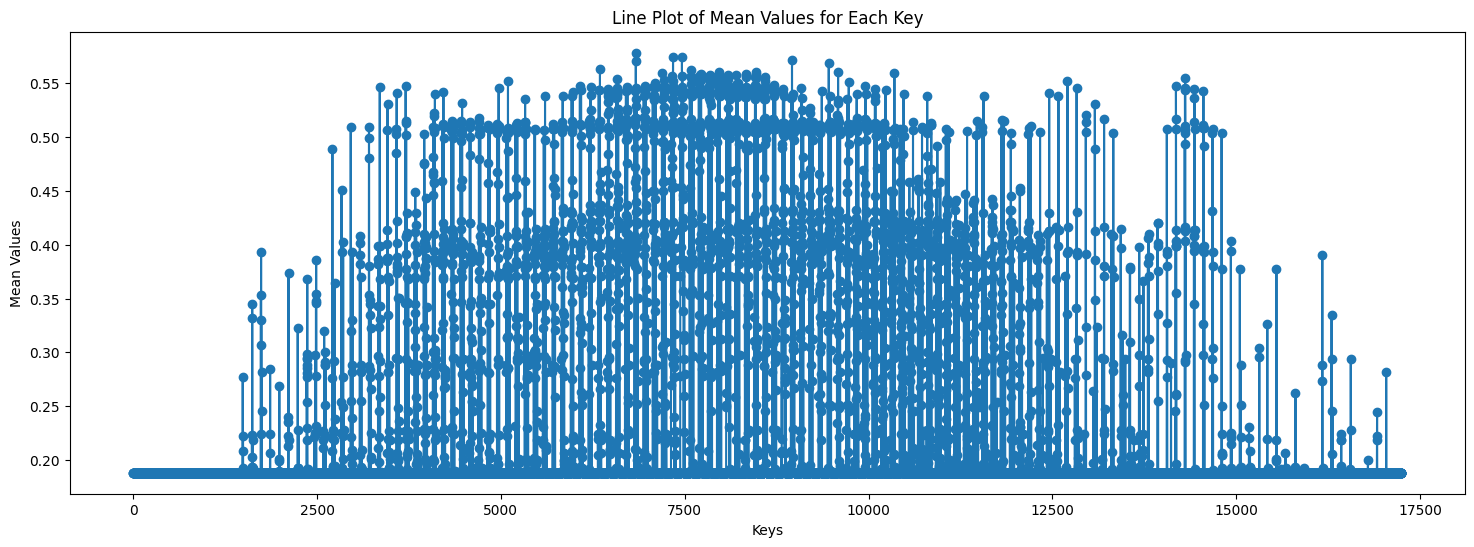

In [39]:
# Calculate the mean for each key
means = {key: sum(values) / len(values) for key, values in pred_dict.items()}
plt.figure(figsize=(18, 6))
# Create a line plot
plt.plot(list(means.keys()), list(means.values()), marker='o', linestyle='-')
plt.xlabel('Keys')
plt.ylabel('Mean Values')
plt.title('Line Plot of Mean Values for Each Key')
plt.show()

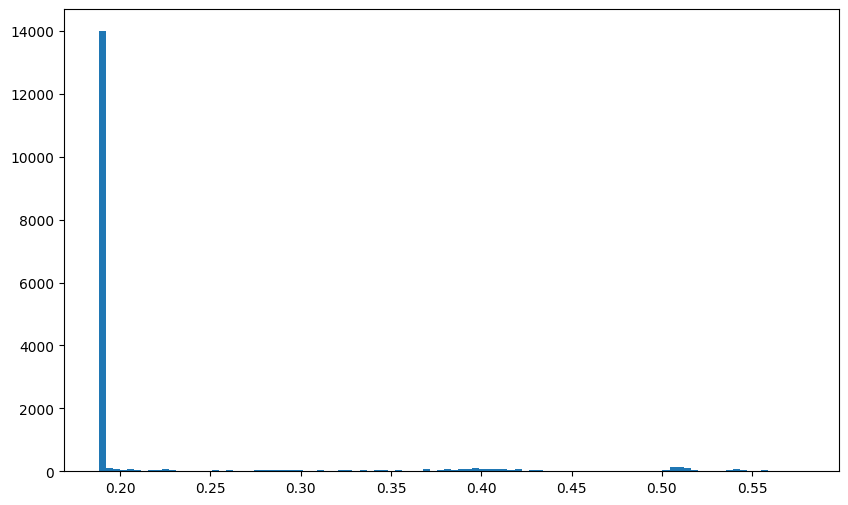

In [40]:
plt.figure(figsize=(10, 6))
plt.hist(list(means.values()), bins=100)
plt.show()
